# 利用Neural ODE从观测数据中学习动力学

本文件是集智学园开发的“大数据驱动的人工智能”系列课程第七节课：《从深度神经网络到Neural ODE》的配套文档。在本文档中，我们定义了一个表示动力学的常微分方程组（用矩阵表示），并采样生成一些有噪声的数据，作为观测数据。然后，使用观测数据训练Neural ODE模型，最后学习可以做到动力学预测。

1. 准备训练数据
2. 定义 Neural ODE 模型
3. 处理划分数据
4. 迭代训练模型、测试结果展示

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第六节课的配套源代码

In [68]:
# 导入所需要的包
import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

use_cuda = torch.cuda.is_available() #判断是否可以使用GPU进行计算
device = torch.device('cuda:0') if use_cuda else torch.device('cpu') #选择使用GPU计算还是CPU

## 一、生成训练数据

我们的数据来源于一个二维非线性系统在不同时刻的运动状态，动力系统的矩阵形式可以表示为：

$$
\dot{\textbf x}=A\textbf x^3
$$

其中：

$$  
A=\begin{bmatrix}-0.1 & 2.0\\-2.0 & -0.1\end{bmatrix}
$$

且：

$$  
 \textbf x = \left(\begin{array} {c} x\\y \end{array}\right)
$$

In [117]:
# Neural ODE模型的超参数
data_size = 1000 # 数据集的大小为1000，即数据集中有1000个样本数据
batch_time = 10 # 一个batch中所包含的连续时间步数为10
batch_size = 20 # 一个batch所包含的样本数量为20
niters = 2300 # 迭代训练的次数为2300
test_freq = 100 # # 每迭代训练10次进行一次测试

In [118]:
true_y0 = torch.tensor([[2.,0.]]).to(device) # true_y0 是真实动力学的初始状态
t = torch.linspace(0.,25.,data_size).to(device) # t 是时间戳，从 0 到 25，共计 data_size 个点
true_A = torch.tensor([[-0.1,2.0],[-2.0,-0.1]]).to(device) # true_A 是真实动力学的参数矩阵

# 定义定义一个类 Lambda表示动力学方程，因为这里使用torchdiffeq中的odeint()函数求数值解
#所以需按规定将动力学定义在nn.Module的子类下
class Lambda(nn.Module):
    def forward(self,t,y):
        return torch.mm(y ** 3, true_A)

true_y = odeint(Lambda().to(device),true_y0,t) # 计算得到的真实结果
train_y = torch.tensor([[[i[0][0]+(torch.randn(1)*0.01).cuda(),i[0][1]+(torch.randn(1)*0.01).cuda()]] for i in true_y]) # 真实结果的基础上加入噪声后得到的观测数据

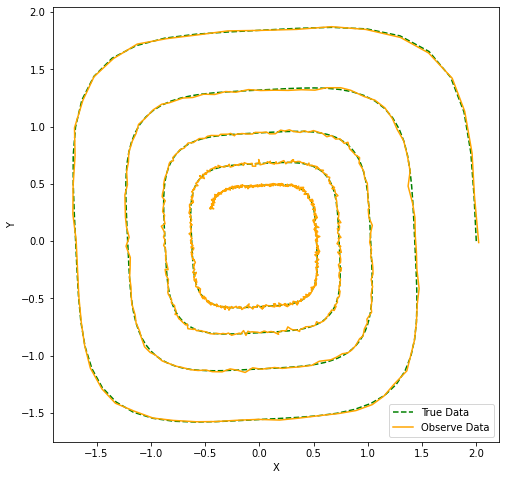

In [129]:
#分别画出上一步得到的真实数据和观测数据，在相空间中的轨迹

plt.figure(figsize=(8,8)) # 创建一个图形窗口，大小为8*8英寸
# 绘制真实数据的图像，第一个参数是x轴数据，第二个参数是y轴数据，第三个参数表示线条样式，c参数指定颜色，label是标签名称
plt.plot([i[:,0].detach().cpu() for i in true_y],[i[:,1].detach().cpu() for i in true_y],'--',c='g',label = 'True Data')
# 绘制观测数据的图像，第一个参数是x轴数据，第二个参数是y轴数据，c参数指定颜色，label是标签名称
plt.plot([i[:,0].detach().cpu() for i in train_y],[i[:,1].detach().cpu() for i in train_y],c='orange',label = 'Observe Data')
plt.legend(loc = 'best') # 添加图例，loc参数指定图例位置
plt.xlabel('X') # 添加x轴标签
plt.ylabel('Y') # 添加y轴标签
plt.show() # 显示图像

## 二、定义Neural ODE模型，目标是让模型学习到动力系统中的参数

In [120]:
class ODEFunc(nn.Module): #继承自nn.Module的神经网络模型ODEFunc
    def __init__(self):
        super(ODEFunc,self).__init__()
        self.net = nn.Sequential( # 网络结构为一个包含两个全连接层的序列模块
            nn.Linear(2,50), # 输入维度为2，输出维度为50的全连接层
            nn.Tanh(), # 双曲正切激活函数
            nn.Linear(50,2), # 输入维度为50，输出维度为2的全连接层
        )
        #对所有的全连接层进行了高斯分布初始化，对偏置进行常数初始化。
        for m in self.net.modules(): # 遍历神经网络的所有模块
            if isinstance(m,nn.Linear): # 判断模块是否为全连接层
                nn.init.normal_(m.weight,mean = 0,std = 0.1) # 对权重进行高斯分布初始化
                nn.init.constant_(m.bias,val = 0) # 对偏置进行常数初始化
                
    def forward(self,t,y):
        return self.net(y ** 3) # 输入数据经过三次方后输入神经网络并返回输出结果

## 三、处理划分训练数据

In [121]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time,dtype = np.int64),batch_size,replace=False)) # 从train_y中随机选择batch_size个数据点，不放回，作为本次batch的起始点
    batch_y0 = train_y[s] # 从train_y中选取起始点s对应的数据点作为本次batch的初始值
    batch_t = t[:batch_time] # 从时间序列t中选取前batch_time个时间点
    batch_y = torch.stack([train_y[s + i] for i in range(batch_time)],dim = 0) # 从s开始向后连续取batch_time个train_y中的数据点，将这些点的tensor按列方向（即时间轴方向）stack起来作为batch_y
    return batch_y0.to(device),batch_t.to(device),batch_y.to(device)

## 四、准备训练结果可视化

In [122]:
# 用于绘制模型的预测结果，可以将真实轨迹和模型预测轨迹进行对比

def visualize(true_y, pred_y, odefunc, itr):

    fig = plt.figure(figsize=(12, 4), facecolor='white') # 创建一个12x4的白色背景的画布
    ax_traj = fig.add_subplot(131, frameon=False) # 创建3个子图，131表示1行3列的第一个图
    ax_phase = fig.add_subplot(132, frameon=False) # 创建3个子图，132表示1行3列的第二个图
    ax_vecfield = fig.add_subplot(133, frameon=False) # 创建3个子图，133表示1行3列的第三个图
    
    ax_traj.cla() # 清空第一个子图
    ax_traj.set_title('Trajectories')  # 给第一个子图添加标题
    ax_traj.set_xlabel('t') # 设置x轴标签
    ax_traj.set_ylabel('x,y') # 设置y轴标签
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-') # 绘制真实数据的x和y坐标轨迹
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--') # 绘制预测数据的x和y坐标轨迹
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max()) # 设置x轴的显示范围
    ax_traj.set_ylim(-2, 2) # 设置y轴的显示范围
    
    ax_phase.cla() # 清空第二个子图
    ax_phase.set_title('Phase Portrait') # 给第二个子图添加标题
    ax_phase.set_xlabel('x') # 设置x轴标签
    ax_phase.set_ylabel('y') # 设置y轴标签
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-') # 绘制真实数据的相空间轨迹
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--') # 绘制预测数据的相空间轨迹
    ax_phase.set_xlim(-2, 2) # 设置x轴的显示范围
    ax_phase.set_ylim(-2, 2) # 设置y轴的显示范围
    
    ax_vecfield.cla() # 清空第三个子图
    ax_vecfield.set_title('Learned Vector Field') # 给第三个子图添加标题
    ax_vecfield.set_xlabel('x') # 设置x轴标签
    ax_vecfield.set_ylabel('y') # 设置y轴标签

    y, x = np.mgrid[-2:2:21j, -2:2:21j] # 生成一组网格点用于绘制向量场，y和x分别代表该网格的纵、横坐标
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy() # 计算每个网格点上的导数值
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1) # 计算每个网格点上的导数大小
    dydt = (dydt / mag) # 将每个网格点上的导数归一化
    dydt = dydt.reshape(21, 21, 2) # 将导数值的形状从(441, 2)转为(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black") # 在向量场上绘制流线
    ax_vecfield.set_xlim(-2, 2) # 设置横坐标范围
    ax_vecfield.set_ylim(-2, 2) # 设置纵坐标范围

    fig.tight_layout() # 调整子图布局
    fig.show() # 显示图像
    plt.pause(0.001) # 暂停0.001秒，以便图像得以展示和更新

## 五、迭代训练模型、测试结果展示

Iter 0001 | Total Loss 8.138810 | Time 0.01min
 


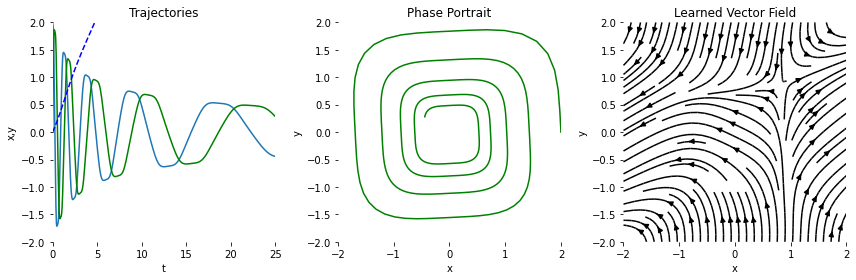

 
Iter 0100 | Total Loss 0.556369 | Time 0.16min
 


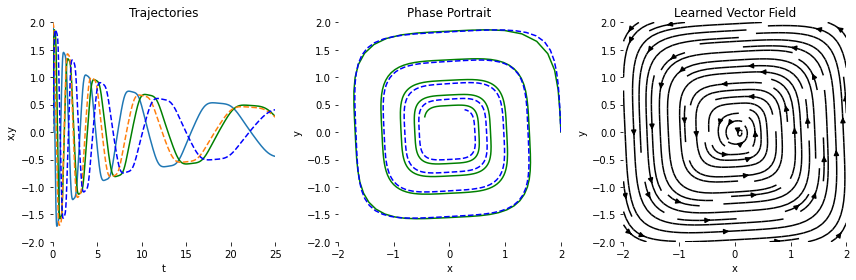

 
Iter 0200 | Total Loss 0.172268 | Time 0.19min
 


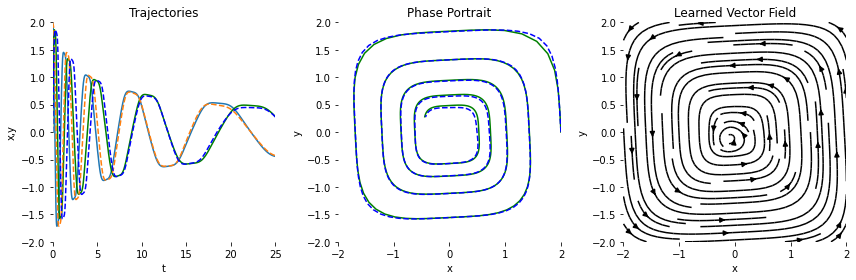

 
Iter 0300 | Total Loss 0.402550 | Time 0.21min
 


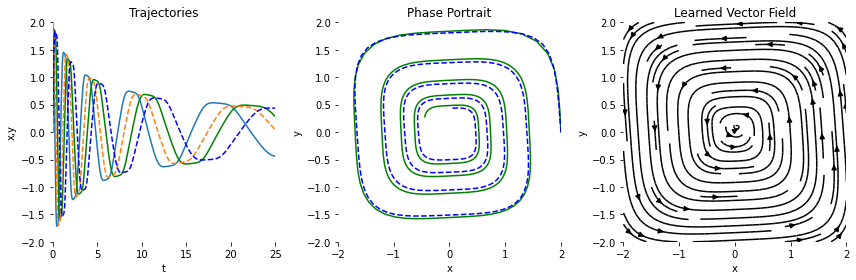

 
Iter 0400 | Total Loss 0.274217 | Time 0.20min
 


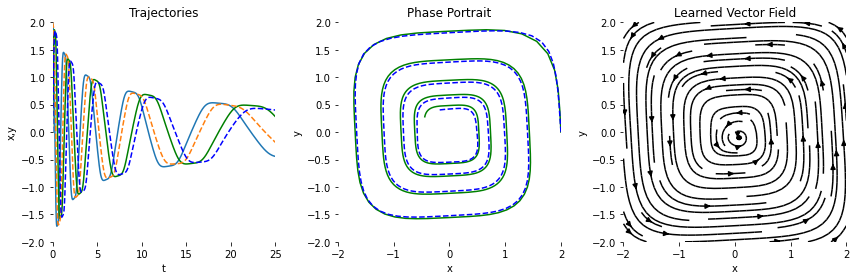

 
Iter 0500 | Total Loss 0.744852 | Time 0.18min
 


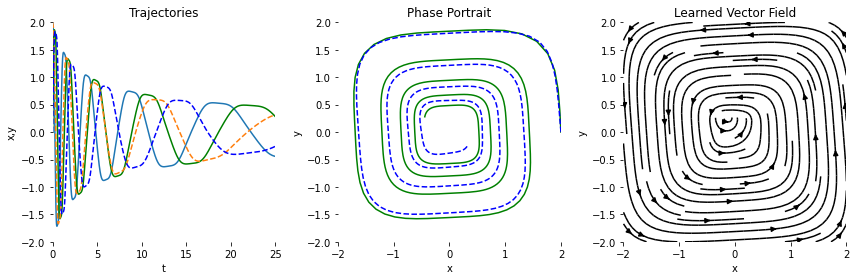

 
Iter 0600 | Total Loss 0.309186 | Time 0.20min
 


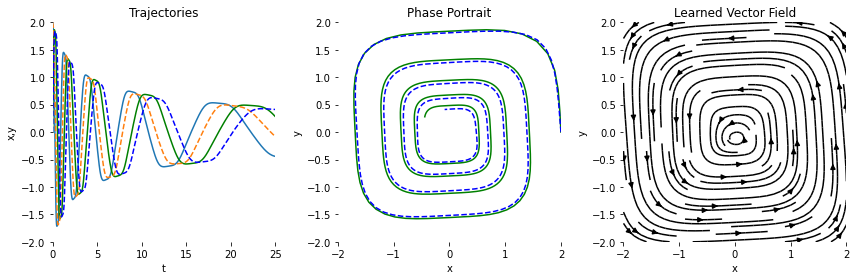

 
Iter 0700 | Total Loss 0.112721 | Time 0.21min
 


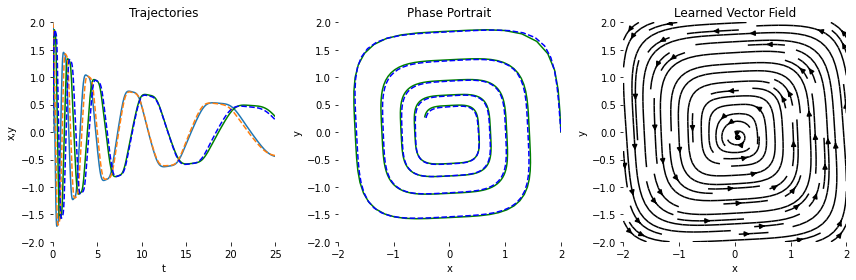

 
Iter 0800 | Total Loss 0.562515 | Time 0.21min
 


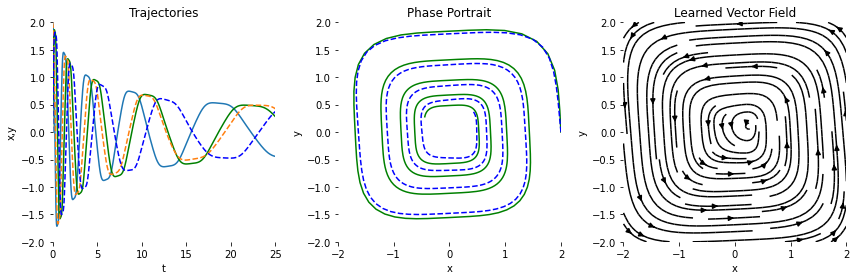

 
Iter 0900 | Total Loss 0.384472 | Time 0.21min
 


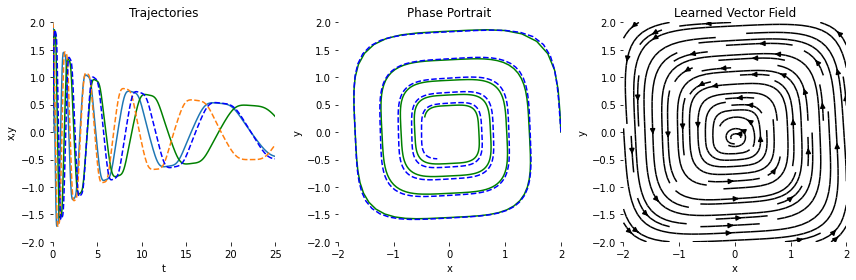

 
Iter 1000 | Total Loss 0.176641 | Time 0.20min
 


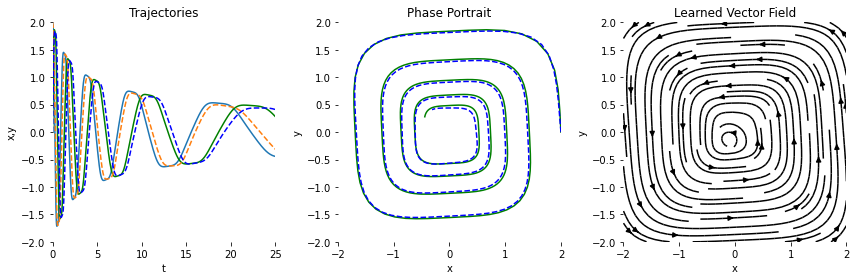

 
Iter 1100 | Total Loss 0.429009 | Time 0.21min
 


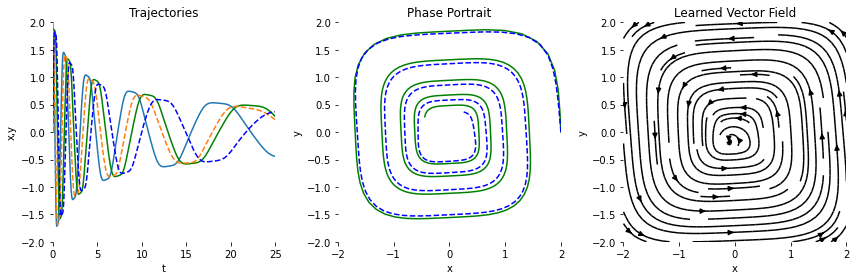

 
Iter 1200 | Total Loss 0.585393 | Time 0.20min
 


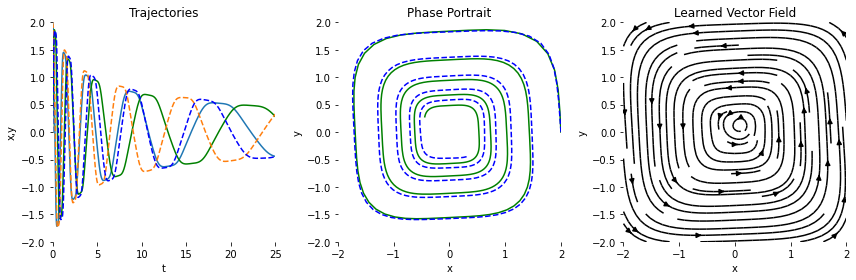

 
Iter 1300 | Total Loss 0.137741 | Time 0.20min
 


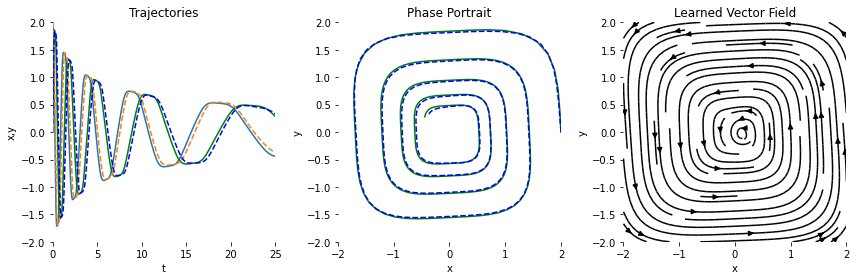

 
Iter 1400 | Total Loss 0.685967 | Time 0.20min
 


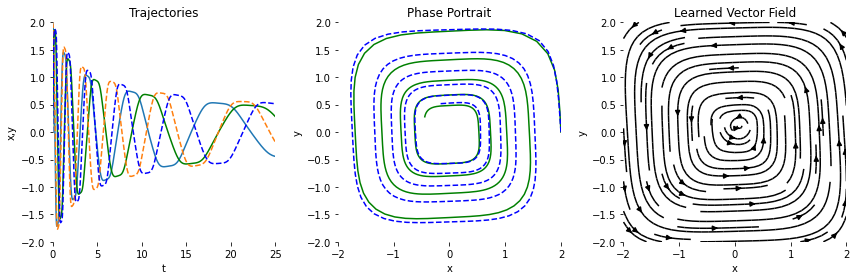

 
Iter 1500 | Total Loss 0.503539 | Time 0.21min
 


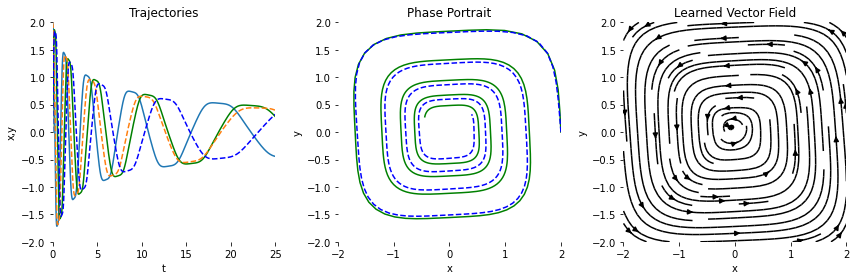

 
Iter 1600 | Total Loss 0.068047 | Time 0.21min
 


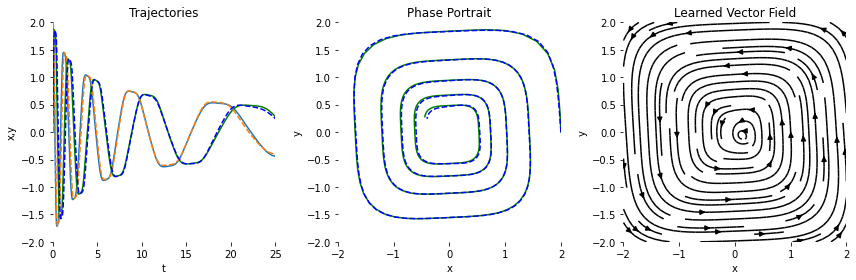

 
Iter 1700 | Total Loss 0.220155 | Time 0.22min
 


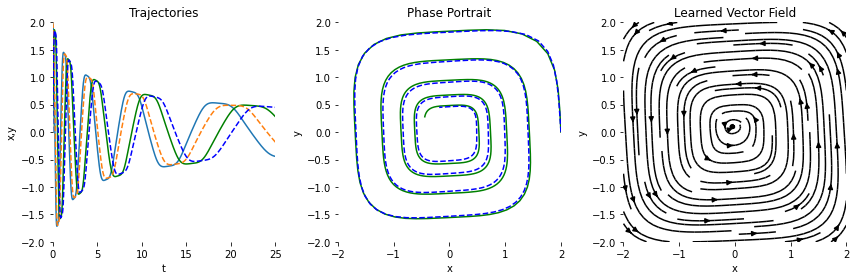

 
Iter 1800 | Total Loss 0.222237 | Time 0.22min
 


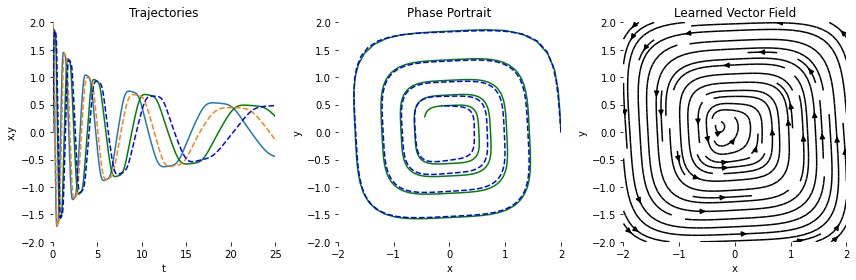

 
Iter 1900 | Total Loss 0.277893 | Time 0.20min
 


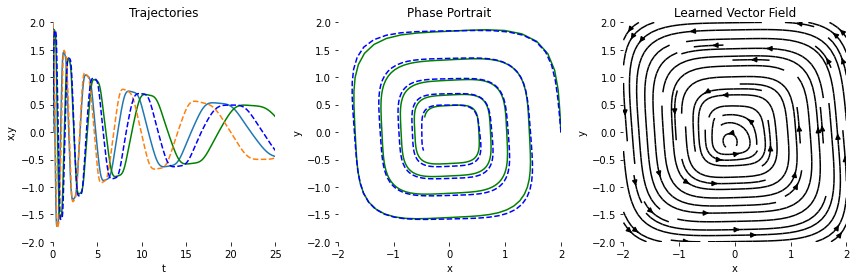

 
Iter 2000 | Total Loss 0.498708 | Time 0.21min
 


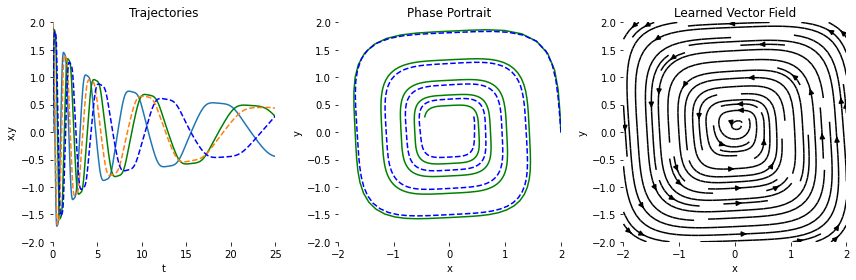

 
Iter 2100 | Total Loss 0.379296 | Time 0.21min
 


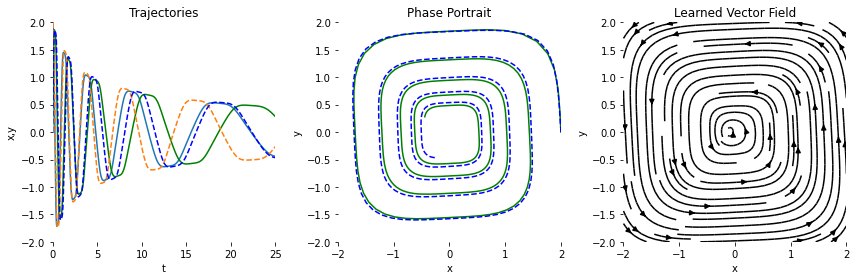

 
Iter 2200 | Total Loss 0.446233 | Time 0.21min
 


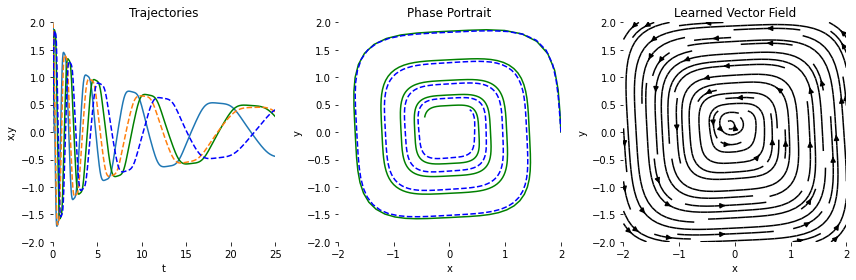

 
Iter 2300 | Total Loss 0.062029 | Time 0.22min
 


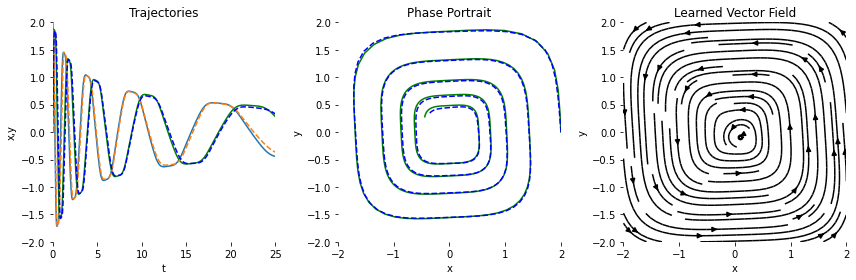

In [131]:
ii = 0 # 训练次数的记录变量
func = ODEFunc().to(device) # 创建ODEFunc实例并移至GPU
optimizer = optim.RMSprop(func.parameters(),lr = 1e-3)  # 定义优化器
end0 = time.time() # 记录初始时间

loss_list = [] # 用于记录每次迭代的loss

for itr in range(1,niters + 1):
    optimizer.zero_grad() # 梯度清零
    batch_y0,batch_t,batch_y = get_batch() # 获取数据集
    pred_y = odeint(func,batch_y0,batch_t).to(device) # 对ODEFunc进行求解并移至GPU，如果我们想使用伴随方法，就将函数改为odeint_adjoint
    loss = torch.mean(torch.abs(pred_y - batch_y )) # 计算loss
    loss.backward() # 反向传播求解梯度
    optimizer.step() # 更新参数
    
    # 记录loss和测试过程
    if (itr == 1) or (itr % test_freq == 0):
        with torch.no_grad():
            pred_y = odeint(func,true_y0,t) # 对ODEFunc进行求解
            loss = torch.mean(torch.abs(pred_y - true_y)) # 计算loss
            end1 = time.time() # 记录当前时间
            print('Iter {:04d} | Total Loss {:.6f} | Time {:.2f}min'.format(itr, loss.item(),(end1 - end0)/60)) # 打印信息
            print(" ")
            loss_list.append(loss.item()) # 记录当前loss
            end0 = end1
            visualize(true_y,pred_y,func,ii) # 调用可视化函数，可视化预测结果与真实结果
            print(" ")
            ii += 1

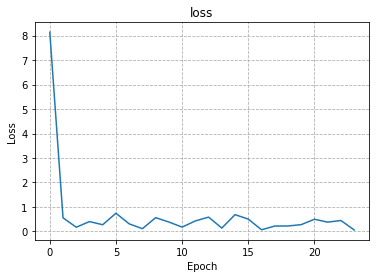

In [133]:
# 绘制Loss值随训练次数的变化曲线
plt.plot(loss_list)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(ls = '--')
plt.title('loss')
plt.show()